<a href="https://colab.research.google.com/github/mit1280/fined-tuning/blob/main/Kosmos_2_fine_tune_PokemonCards_trl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvidia-smi

Sat Apr 13 18:49:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install -q -U transformers accelerate bitsandbytes seqeval evaluate trl peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 k

In [ ]:
from transformers import AutoProcessor, AutoModelForVision2Seq
import requests
from datasets import load_dataset
from datasets.features import ClassLabel
import re
from PIL import Image, ImageDraw, ImageFont
import math
import random
from transformers import Kosmos2Config, Kosmos2Model, Kosmos2ForConditionalGeneration, AutoProcessor, BitsAndBytesConfig, TrainingArguments
import torch
from io import BytesIO

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = Kosmos2ForConditionalGeneration.from_pretrained("microsoft/kosmos-2-patch14-224", device_map="auto", low_cpu_mem_usage=True)
processor = AutoProcessor.from_pretrained("microsoft/kosmos-2-patch14-224", add_eos_token=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Load data from huggingface
dataset = load_dataset("TheFusion21/PokemonCards", split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/13139 [00:00<?, ? examples/s]

In [ ]:
dataset

Dataset({
    features: ['id', 'image_url', 'caption', 'name', 'hp', 'set_name'],
    num_rows: 13139
})

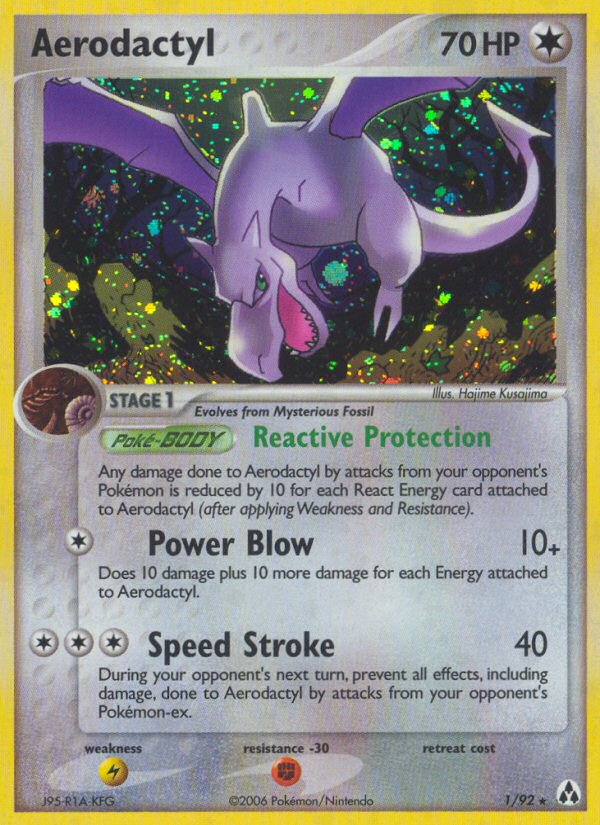

In [ ]:
# load image
example = dataset[1]
image_url = example["image_url"]
response = requests.get(image_url)
# Read the image from the response content
image = Image.open(BytesIO(response.content))
image

In [ ]:
example

{'id': 'ex12-1',
 'image_url': 'https://images.pokemontcg.io/ex12/1_hires.png',
 'caption': "A Stage 1 Pokemon Card of type Colorless with the title Aerodactyl and 70 HP of rarity Rare Holo evolved from Mysterious Fossil from the set Legend Maker.  It has the attack Power Blow with the cost Colorless, the energy cost 1 and the damage of 10+ with the description: Does 10 damage plus 10 more damage for each Energy attached to Aerodactyl. It has the attack Speed Stroke with the cost Colorless, Colorless, Colorless, the energy cost 3 and the damage of 40 with the description: During your opponent's next turn, prevent all effects, including damage, done to Aerodactyl by attacks from your opponent's Pokemon-ex. It has the ability Reactive Protection with the description: Any damage done to Aerodactyl by attacks from your opponent's Pokemon is reduced by 10 for each React Energy card attached to Aerodactyl (after applying Weakness and Resistance). It has weakness against Lightning 2. It has r

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
class Kosmos2DataCollator:
    def __init__(self, processor):
        self.processor = processor

    def __call__(self, examples):
        texts = []
        images = []
        bboxes = []
        for example in examples:
            texts.append(example['caption'])
            image_url = example["image_url"]
            images.append(Image.open(BytesIO(requests.get(image_url).content)))


        batch = self.processor(images = images, text = texts, return_tensors="pt", truncation= True, padding=True)

        labels = batch["input_ids"].clone()
        if self.processor.tokenizer.pad_token_id is not None:
            labels[labels == self.processor.tokenizer.pad_token_id] = -100
        batch["labels"] = labels

        return batch

data_collator = Kosmos2DataCollator(processor)

In [ ]:
training_args = TrainingArguments(
    output_dir="Kosmos-2-PokemonCards-trl",
    learning_rate=1.4e-5,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=2,
    eval_accumulation_steps=2,
    evaluation_strategy="steps",
    logging_steps=1000,
    eval_steps=500,
    num_train_epochs=100,
    push_to_hub=False,
    gradient_checkpointing=True,
    remove_unused_columns=False,
    fp16=True,
    bf16=False
)

In [ ]:
from peft import LoraConfig
lora_config = LoraConfig(
    r=64,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj"]
)

#### Do this befor running train()

https://discuss.huggingface.co/t/kosmos-2-fine-tuning/75691/26?u=mit1208

In [ ]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset.select(range(300)),
    eval_dataset=dataset.select(range(10)),
    peft_config=lora_config,
    dataset_text_field="caption",  # need a dummy field
    tokenizer=processor.tokenizer,
    data_collator=data_collator,
    dataset_kwargs={"skip_prepare_dataset": True},
)

trainer.train()


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss,Validation Loss
500,No log,No log
1000,2.749600,No log
1500,2.749600,No log
2000,1.294300,No log
2500,1.294300,No log
3000,0.919300,No log
3500,0.919300,No log
4000,0.801400,No log
4500,0.801400,No log


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs fo

Step,Training Loss,Validation Loss
500,No log,No log
1000,2.749600,No log
1500,2.749600,No log
2000,1.294300,No log
2500,1.294300,No log
3000,0.919300,No log
3500,0.919300,No log
4000,0.801400,No log
4500,0.801400,No log
5000,0.740900,No log


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs fo

In [ ]:
# base_model = Kosmos2ForConditionalGeneration.from_pretrained(
#     "microsoft/kosmos-2-patch14-224",
#     low_cpu_mem_usage=True,
#     return_dict=True,
#     torch_dtype=torch.float16,
# )
# from peft import LoraConfig, PeftModel

# temp_model = PeftModel.from_pretrained(base_model, "./classification")
temp_model = model.merge_and_unload()

In [ ]:
temp_model.save_pretrained("Kosmos-2-PokemonCards-trl-merged")
processor.save_pretrained("Kosmos-2-PokemonCards-trl-merged")

In [ ]:
temp_model.push_to_hub("Kosmos-2-PokemonCards-trl-merged", use_temp_dir=False)
processor.push_to_hub("Kosmos-2-PokemonCards-trl-merged", use_temp_dir=False)

model.safetensors:   0%|          | 0.00/3.33G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Mit1208/kosmos-2-doclaynet-trl/commit/2b1a25d2427fc19d44bd18a46a8670233d3c59b4', commit_message='Upload processor', commit_description='', oid='2b1a25d2427fc19d44bd18a46a8670233d3c59b4', pr_url=None, pr_revision=None, pr_num=None)

## Reference

1. https://discuss.huggingface.co/t/kosmos-2-fine-tuning/75691
2. https://huggingface.co/blog/vlms
